In [13]:
import aniposelib
import numpy as np
import pandas as pd
from aniposelib.cameras import CameraGroup
from aniposelib.boards import CharucoBoard, Checkerboard
from aniposelib.cameras import Camera




vidnames = [['calib_cam1_cropped_new.mp4'],['calib_cam2_cropped_new.mp4']]

camera_names = ['cam1', 'cam2']
cgroup = CameraGroup.from_names(camera_names)

board = CharucoBoard(5,7,square_length=40,marker_length=20,marker_bits=6,dict_size=250)
cgroup.calibrate_videos(vidnames, board)
cgroup.dump('calibration.toml')

cgroup = CameraGroup.load('calibration.toml')




calib_cam1_cropped_new.mp4


  0%|                                         | 0/754 [00:00<?, ?it/s]

 94%|█████████████████████████████  | 708/754 [01:34<00:06,  7.47it/s]


604 boards detected
calib_cam2_cropped_new.mp4


100%|██████████████████████████████▉| 765/767 [01:31<00:00,  8.39it/s]


712 boards detected
[{'name': 'cam1', 'size': [1920, 1080], 'matrix': [[5712.694408149805, 0.0, 959.5], [0.0, 5712.694408149805, 539.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam2', 'size': [1920, 1080], 'matrix': [[7263.850440726959, 0.0, 959.5], [0.0, 7263.850440726959, 539.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>, {('cam1', 'cam2'): 569, ('cam2', 'cam1'): 569})
error:  30.090810583395783
n_samples: 200
{(0, 1): (1000, array([ 8.86252292, 64.95299871]))}
error: 30.67, mu: 15.0, ratio: 0.253
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7258e+04                                    2.82e+06    
       1              2         1.5654e+04      3.16e+04       4.15e+03       3.06e+05    
       2              4 

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ENTER YOUR REQUIREMENTS HERE:
ARUCO_DICT = cv2.aruco.DICT_6X6_250
SQUARES_VERTICALLY = 7
SQUARES_HORIZONTALLY = 5
SQUARE_LENGTH = 0.04
PATH_TO_YOUR_IMAGES = '/Users/imguest.DESKTOP-6DE526B/Documents/Alzheimers Project/calibration_images'
MARKER_LENGTH = 0.02
# ...
# ------------------------------
#Save all frames from video in calibration_images folder
def save_frames_from_video(video_path):
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    while success and count < 100:
        cv2.imwrite(os.path.join(PATH_TO_YOUR_IMAGES, f'frame{count}.png'), image)     # save frame as JPEG file      
        success,image = vidcap.read()
        count += 1

save_frames_from_video('calib_cam1_cropped 1.mp4')
def calibrate_and_save_parameters():
    # Define the aruco dictionary and charuco board
    dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
    board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
    params = cv2.aruco.DetectorParameters()

    # Load PNG images from folder
    image_files = [os.path.join(PATH_TO_YOUR_IMAGES, f) for f in os.listdir(PATH_TO_YOUR_IMAGES) if f.endswith(".png")]
    image_files.sort()  # Ensure files are in order

    all_charuco_corners = []
    all_charuco_ids = []

    for image_file in image_files:
        image = cv2.imread(image_file)
        image_copy = image.copy()
        print(image_file)
        
        marker_corners, marker_ids, _ = cv2.aruco.detectMarkers(image_copy, dictionary, parameters=params)
        print(marker_corners, marker_ids)
        
        # If at least one marker is detected and the board is detected, interpolate charuco corners
        if marker_corners is not None and marker_ids is not None:
            if len(marker_ids) > 0:
                cv2.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids)
                charuco_retval, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)
                if charuco_retval:
                    all_charuco_corners.append(charuco_corners)
                    all_charuco_ids.append(charuco_ids)
                
                # Display image
                plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
                plt.show()

        
    # Calibrate camera
    retval, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.aruco.calibrateCameraCharuco(all_charuco_corners, all_charuco_ids, board, image.shape[:2], None, None)

    # Save calibration data
    np.save('camera_matrix.npy', camera_matrix)
    np.save('dist_coeffs.npy', dist_coeffs)

    # Iterate through displaying all the images
    for image_file in image_files:
        image = cv2.imread(image_file)
        undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)
        cv2.imshow('Undistorted Image', undistorted_image)
        cv2.waitKey(0)

    cv2.destroyAllWindows()

calibrate_and_save_parameters()

In [8]:
csv_files = ['keypoints_cam1_vid1.csv', 'keypoints_cam2_vid1.csv']

score_threshold = 0.5


n_cams = len(csv_files)
n_frames = max(pd.read_csv(csv_files[1])['frame']) + 1
n_joints = 17

body_parts = ['nose', 'right_shoulder', 'right_elbow', 'right_wrist', 'left_shoulder', 'left_elbow', 'left_wrist', 'right_hip', 'right_knee', 'right_ankle', 'left_hip', 'left_knee', 'left_ankle', 'right_eye', 'left_eye', 'right_ear', 'left_ear']
print(len(body_parts))
#make one dictionary to store the points and confidence levels and camera
all_detections = np.zeros((n_cams, n_frames, n_joints, 2))
confidence_levels = np.zeros((n_cams, n_frames, n_joints))

for c, csv_file in enumerate(csv_files):
    # Load the data
    df = pd.read_csv(csv_file)  
    # Group the DataFrame by the 'frame' column
    grouped = df.groupby('frame')

    # For each frame, extract the points and confidence levels
    for f, (name, group) in enumerate(grouped):
        points = group[['x', 'y']].values
        if(points.shape[0] > 17):
            points = points[:17]
        print(str(f) + ': ' + str(points.shape))
        print(points)
        score = group['confidence'].values
        if(score.shape[0] > 17):
            score = score[:17]
        print('F: ',f)
        print('C: ', c)
        confidence_levels[c, f, :len(score)] = score
        all_detections[c, f] = points
        
    print(all_detections.shape)


#flatten the points
points_flat = all_detections.reshape(n_cams, -1, 2)
print("Points Flat: ", points_flat)
confidence_levels_flat = confidence_levels.reshape(n_cams, -1)
print(confidence_levels_flat)

p3ds_flat = cgroup.triangulate(points_flat, undistort=False,  progress = True)
print("After Triangulation: ", p3ds_flat)
reprojerr_flat = cgroup.reprojection_error(p3ds_flat, points_flat, mean=True)
print(reprojerr_flat)

p3ds = p3ds_flat.reshape(n_frames, n_joints, 3)
print(p3ds)
reprojerr = reprojerr_flat.reshape(n_frames, n_joints)




17
0: (17, 2)
[[1290.0026   347.18073]
 [1310.6296   318.63455]
 [1252.5696   323.5808 ]
 [1336.364    344.08548]
 [1194.0072   355.3876 ]
 [1419.9529   535.8276 ]
 [1111.8223   536.1034 ]
 [1485.8108   738.0868 ]
 [1017.93823  732.06866]
 [1522.5177   900.6969 ]
 [ 991.4131   894.48706]
 [1394.3267   987.4093 ]
 [1183.4938   991.19385]
 [   0.         0.     ]
 [   0.         0.     ]
 [   0.         0.     ]
 [   0.         0.     ]]
F:  0
C:  0
1: (17, 2)
[[1304.6233   345.95514]
 [1324.6753   317.2007 ]
 [1266.927    321.1462 ]
 [1349.3245   344.30835]
 [1207.8137   355.0331 ]
 [1433.5941   530.931  ]
 [1124.4369   533.82355]
 [1498.1206   729.85425]
 [1032.0397   724.46106]
 [1537.8724   905.42786]
 [ 993.53455  899.0587 ]
 [1399.6816   986.3659 ]
 [1187.4369   988.4479 ]
 [   0.         0.     ]
 [   0.         0.     ]
 [   0.         0.     ]
 [   0.         0.     ]]
F:  1
C:  0
2: (17, 2)
[[1318.3732   346.45865]
 [1337.7632   317.42133]
 [1281.2607   321.57767]
 [1360.6036  

100%|█████████████████████████| 11271/11271 [00:01<00:00, 9253.54it/s]


After Triangulation:  [[-3.15307984e+03 -1.95629258e+01  8.23984257e+03]
 [-3.14756362e+03  2.33107858e+01  8.23988256e+03]
 [-3.15063102e+03 -9.80221267e-01  8.23977521e+03]
 ...
 [-4.44388854e+01  6.65586120e+00  1.03604800e+04]
 [-4.44388854e+01  6.65586120e+00  1.03604800e+04]
 [-4.44388854e+01  6.65586120e+00  1.03604800e+04]]
[2.24328190e+15 2.76031154e+16 5.61664127e+15 ... 1.10086935e+03
 1.10086935e+03 1.10086935e+03]
[[[-3.15307984e+03 -1.95629258e+01  8.23984257e+03]
  [-3.14756362e+03  2.33107858e+01  8.23988256e+03]
  [-3.15063102e+03 -9.80221267e-01  8.23977521e+03]
  ...
  [-4.44388854e+01  6.65586120e+00  1.03604800e+04]
  [-4.44388854e+01  6.65586120e+00  1.03604800e+04]
  [-4.44388854e+01  6.65586120e+00  1.03604800e+04]]

 [[-3.15232038e+03 -1.35325628e+01  8.23986859e+03]
  [-3.14686605e+03  2.88566163e+01  8.23990708e+03]
  [-3.14969806e+03  6.40284443e+00  8.23980240e+03]
  ...
  [-4.44388854e+01  6.65586120e+00  1.03604800e+04]
  [-4.44388854e+01  6.65586120e+00 

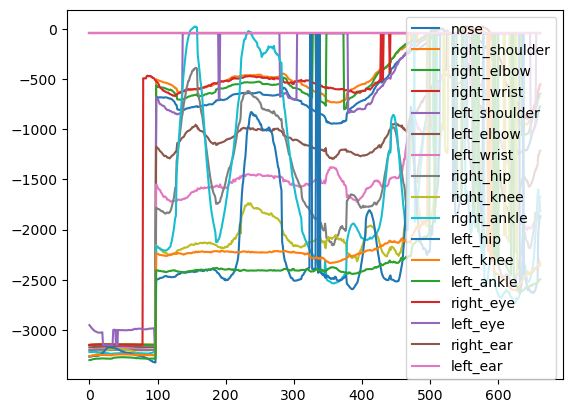

In [9]:
import matplotlib.pyplot as plt

#plot the body part over time
for i in range(n_joints):
    plt.plot(p3ds[:,i,0], label=body_parts[i])
plt.legend()
plt.show()




17
{'nose': 0, 'right_shoulder': 1, 'right_elbow': 2, 'right_wrist': 3, 'left_shoulder': 4, 'left_elbow': 5, 'left_wrist': 6, 'right_hip': 7, 'right_knee': 8, 'right_ankle': 9, 'left_hip': 10, 'left_knee': 11, 'left_ankle': 12, 'right_eye': 13, 'left_eye': 14, 'right_ear': 15, 'left_ear': 16}
Connecting: ['right_shoulder', 'right_elbow', 'right_wrist']
Connecting: ['left_shoulder', 'left_elbow', 'left_wrist']
Connecting: ['right_hip', 'right_knee', 'right_ankle']
Connecting: ['left_hip', 'left_knee', 'left_ankle']
Connecting: ['right_eye', 'nose', 'left_eye']
Connecting: ['right_ear', 'nose', 'left_ear']
Connecting: ['right_shoulder', 'left_shoulder']
Connecting: ['right_hip', 'left_hip']


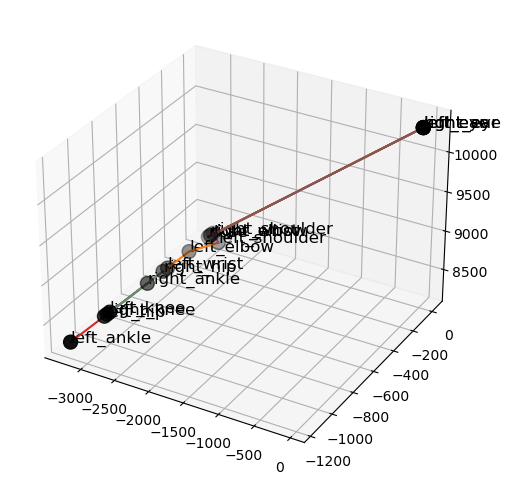

17
{'nose': 0, 'right_shoulder': 1, 'right_elbow': 2, 'right_wrist': 3, 'left_shoulder': 4, 'left_elbow': 5, 'left_wrist': 6, 'right_hip': 7, 'right_knee': 8, 'right_ankle': 9, 'left_hip': 10, 'left_knee': 11, 'left_ankle': 12, 'right_eye': 13, 'left_eye': 14, 'right_ear': 15, 'left_ear': 16}
Connecting: ['right_shoulder', 'right_elbow', 'right_wrist']
Connecting: ['left_shoulder', 'left_elbow', 'left_wrist']
Connecting: ['right_hip', 'right_knee', 'right_ankle']
Connecting: ['left_hip', 'left_knee', 'left_ankle']
Connecting: ['right_eye', 'nose', 'left_eye']
Connecting: ['right_ear', 'nose', 'left_ear']
Connecting: ['right_shoulder', 'left_shoulder']
Connecting: ['right_hip', 'left_hip']
17
{'nose': 0, 'right_shoulder': 1, 'right_elbow': 2, 'right_wrist': 3, 'left_shoulder': 4, 'left_elbow': 5, 'left_wrist': 6, 'right_hip': 7, 'right_knee': 8, 'right_ankle': 9, 'left_hip': 10, 'left_knee': 11, 'left_ankle': 12, 'right_eye': 13, 'left_eye': 14, 'right_ear': 15, 'left_ear': 16}
Connecti

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import get_cmap

def connect(ax, points, bps, bp_dict, color):
    ixs = [bp_dict[bp] for bp in bps]
    return ax.plot(points[ixs, 0], points[ixs, 1], points[ixs, 2], color=color)

def connect_all(ax, points, scheme, bodyparts, cmap=None):
    if cmap is None:
        cmap = get_cmap('tab10')
    bp_dict = dict(zip(bodyparts, range(len(bodyparts))))
    lines = []
    print(len(p3d))

    print(bp_dict)

    for i, bps in enumerate(scheme):
        print(f"Connecting: {bps}")
        line = connect(ax, p3d, bps, bp_dict, color=cmap(i)[:3])
    return lines

scheme = [
    ["right_shoulder", "right_elbow", "right_wrist"],
    ["left_shoulder", "left_elbow", "left_wrist"],
    ["right_hip", "right_knee", "right_ankle"],
    ["left_hip", "left_knee", "left_ankle"],
    ["right_eye", "nose", "left_eye"],
    ["right_ear", "nose", "left_ear"],
    ["right_shoulder", "left_shoulder"],
    ["right_hip", "left_hip"],
]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for framenum in range(n_frames):
    p3d = p3ds[framenum]

    ax.clear()
    ax.scatter(p3d[:,0], p3d[:,1], p3d[:,2], c='black', s=100)
    #label the points
    for i, txt in enumerate(body_parts):
        ax.text(p3d[i,0], p3d[i,1], p3d[i,2], txt, size=12, zorder=1, color='k')
    connect_all(ax, p3d, scheme, body_parts)

    plt.show()


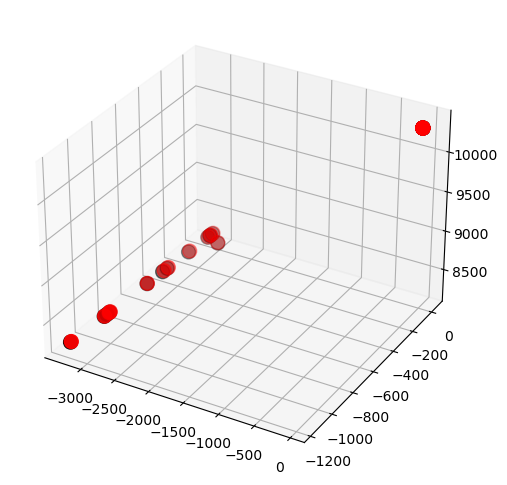